# Tree Classification

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.basic_analysis import BasicDataAnalysis
from utils.visualization_histogram import HistogramDataVisualization

from utils.time_series_aggregate import TimeSeriesAggregate
from utils.visualization_spectral import SpectralBandPlotter


from utils.data_loader import DataLoader
from utils.basic_analysis import BasicDataAnalysis
from utils.feature_engineering import FeatureEngineering
from utils.correlation_analysis import CorrelationAnalysis

from utils.time_series_aggregate import TimeSeriesAggregate


from utils.visualization_spectral import SpectralBandPlotter
from utils.visualization_histogram import HistogramDataVisualization
from utils.visualization_function import (
    plot_intervals_timestamps,
    plot_top_correlations,
    plot_autocorrelation
)

In [86]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/raw_trainset.csv")

## Basic Data Analysis

In [87]:
basicanalysis = BasicDataAnalysis(df_base)
basicanalysis.get_dtypes()

time                datetime64[ns]
id                           int64
disturbance_year             int64
doy                          int64
b2                           int64
b3                           int64
b4                           int64
b5                           int64
b6                           int64
b7                           int64
b8                           int64
b8a                          int64
b11                          int64
b12                          int64
species                     object
dtype: object

In [88]:
print(f"Raw Dataset cols:{basicanalysis.get_num_cols()}")
print(f"Raw Dataset rows:{basicanalysis.get_num_rows()}")

Raw Dataset cols:15
Raw Dataset rows:4074354


In [89]:
basicanalysis.get_desricption()

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,b8,b8a,b11,b12
count,4074354,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06,4.074354e+06
mean,2020-02-05 05:16:36.360551936,1.408675e+04,2.522988e+02,1.763385e+02,2.726073e+02,4.309495e+02,3.465769e+02,6.764691e+02,1.683092e+03,2.040237e+03,2.166979e+03,2.290828e+03,1.158527e+03,6.015298e+02
min,2017-01-01 00:00:00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2018-09-24 00:00:00,7.038000e+03,0.000000e+00,1.060000e+02,1.560000e+02,2.810000e+02,1.750000e+02,4.600000e+02,1.268000e+03,1.529000e+03,1.629000e+03,1.741000e+03,7.300000e+02,3.360000e+02
50%,2020-03-15 00:00:00,1.406300e+04,0.000000e+00,1.760000e+02,2.230000e+02,3.710000e+02,2.570000e+02,5.880000e+02,1.547000e+03,1.856000e+03,1.971000e+03,2.092000e+03,1.011000e+03,4.810000e+02
75%,2021-06-16 00:00:00,2.113300e+04,0.000000e+00,2.450000e+02,3.220000e+02,5.030000e+02,3.990000e+02,7.840000e+02,1.924000e+03,2.327000e+03,2.464000e+03,2.610000e+03,1.441000e+03,7.090000e+02
max,2022-11-02 00:00:00,2.821200e+04,2.020000e+03,3.660000e+02,2.008700e+04,1.753400e+04,1.752400e+04,1.794000e+04,1.982700e+04,2.143900e+04,2.181100e+04,2.469400e+04,1.855400e+04,1.758700e+04
std,NaN,8.145028e+03,6.675001e+02,8.521531e+01,2.202539e+02,2.602215e+02,3.086128e+02,3.482985e+02,6.457464e+02,8.024451e+02,8.532377e+02,8.597645e+02,6.092414e+02,4.196677e+02


In [90]:
basicanalysis.get_missing_counts()

time                0
id                  0
disturbance_year    0
doy                 0
b2                  0
b3                  0
b4                  0
b5                  0
b6                  0
b7                  0
b8                  0
b8a                 0
b11                 0
b12                 0
species             0
dtype: int64

## Feature Engineering

### Datetime Feature Engineering

In [91]:
df = dataloader.date_feature_extraction(df_base)

### Advanced Feature Engineering

In [92]:
calcindices = CalculateIndices()
df = calcindices.add_all_indices(df)

In [93]:
df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
808190,2017-03-13,1,0,72,147,204,145,400,1193,1435,...,0.833142,0.751068,1520.5,1.154617,1.249353,0.916571,562.758621,-32.156368,-0.999372,1448
808191,2017-03-27,1,0,86,137,222,154,389,1247,1561,...,0.819988,0.750981,1480.0,1.148907,1.229623,0.909994,474.883117,-32.434732,-0.999358,1403
808192,2017-04-09,1,0,99,160,248,169,395,1209,1454,...,0.801059,0.708578,1445.5,1.140640,1.201236,0.900530,422.579882,-31.197789,-0.999347,1361
808193,2017-04-22,1,0,112,146,247,152,391,1354,1628,...,0.833333,0.736533,1596.0,1.154701,1.249657,0.916667,491.836842,-30.333333,-0.999402,1520
808194,2017-04-29,1,0,119,171,264,186,419,1353,1731,...,0.813253,0.735338,1713.0,1.145973,1.219573,0.906627,419.901075,-32.782655,-0.999446,1620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311855,2022-09-05,28212,0,248,318,450,338,619,1664,2012,...,0.740897,0.634444,2102.0,1.113956,1.111132,0.870448,411.689941,-31.960766,-0.999560,1933
3311856,2022-09-24,28212,0,267,202,334,229,513,1666,2136,...,0.815024,0.729555,2132.5,1.146745,1.222290,0.907512,508.967686,-32.916739,-0.999555,2018
3311857,2022-10-03,28212,0,276,184,311,205,504,1580,1910,...,0.813382,0.719946,1889.5,1.146029,1.219795,0.906691,588.081951,-31.509294,-0.999498,1787
3311858,2022-10-27,28212,0,300,353,560,362,732,1944,2254,...,0.749654,0.601990,2349.0,1.117879,1.124287,0.874827,598.541436,-31.247525,-0.999605,2168


## Exploratory Data Analysis

### Visualization Base-Dataframe 

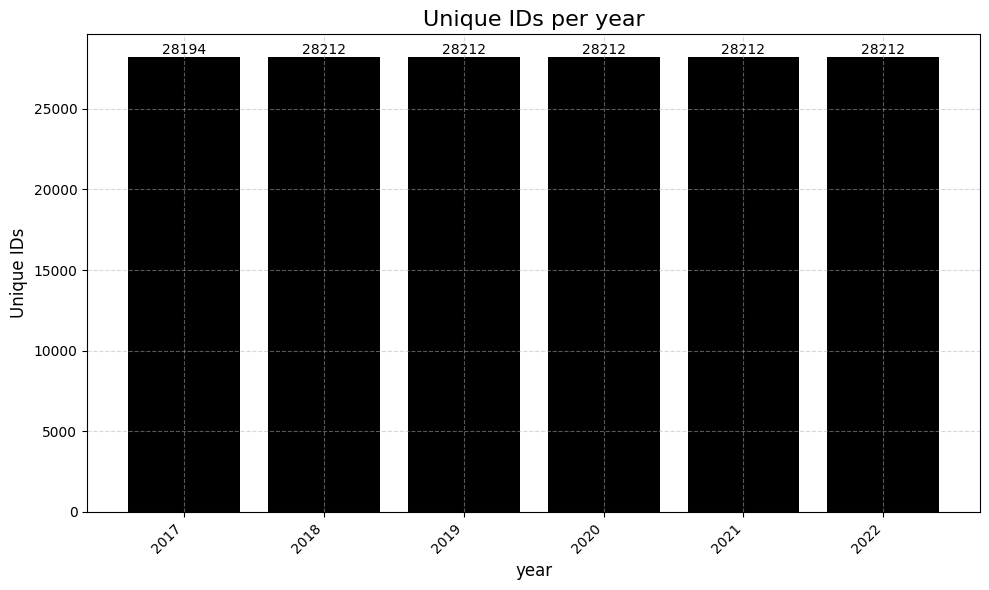

In [94]:
hist = HistogramDataVisualization(df)
hist.plot_unique_ids("year")

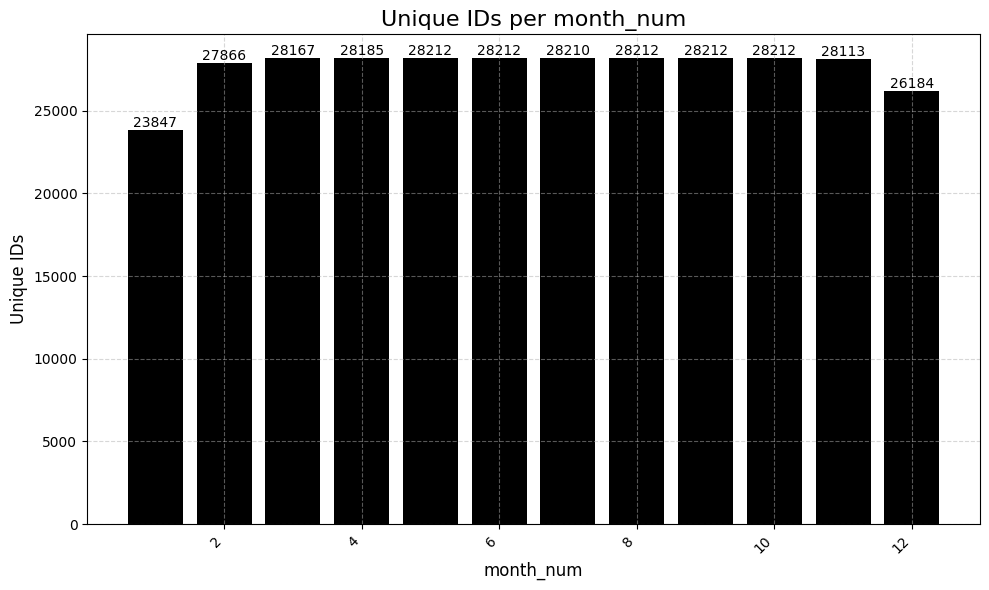

In [95]:
hist.plot_unique_ids("month_num")

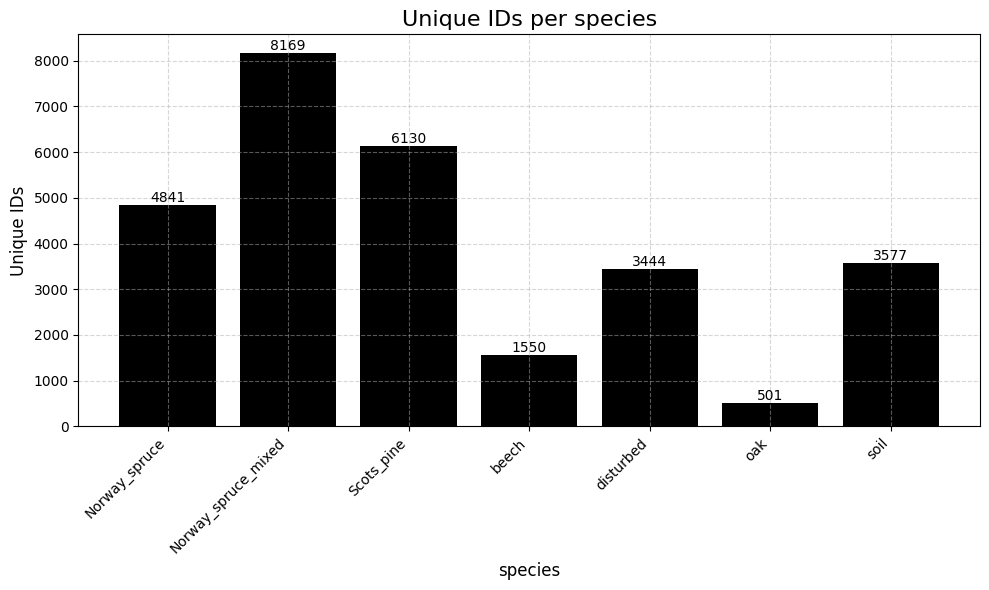

In [96]:
hist.plot_unique_ids("species")

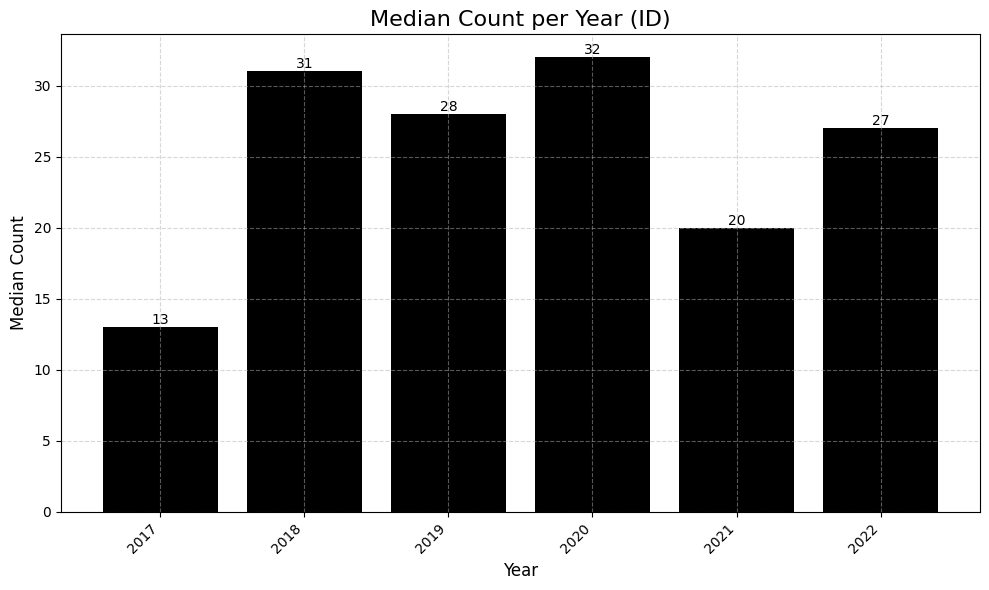

In [97]:
hist.plot_median_id_distribution()

## Disturbed

In [98]:
# Boolesche Spalte erstellen
df["disturbed"] = df["disturbance_year"].apply(lambda x: False if x == 0 else True)

In [99]:
unique_values = df["disturbance_year"].unique()
print(f"Nunique: {len(unique_values)}")
print(f"Unique Values:\n{unique_values}")

Nunique: 22
Unique Values:
[   0 2018 2020 2014 2011 2017 2019 2013 2009 2016 2015 2006 2012 2007
 2004 2003 1986 2005 1998 1995 2001 2010]


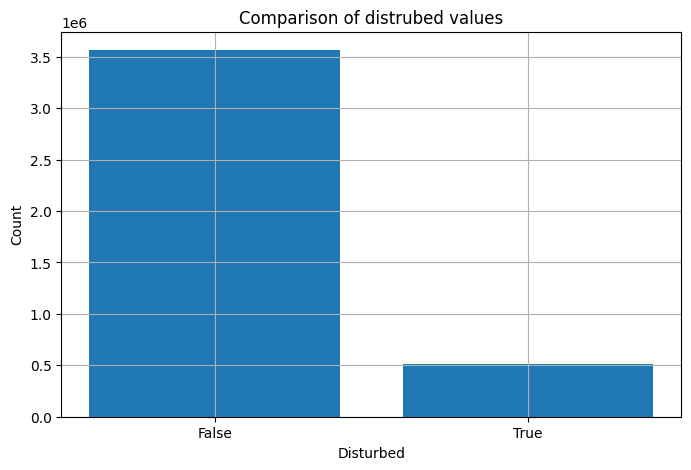

In [100]:
dist_disturbance_df = df["disturbed"].value_counts().reset_index()
dist_disturbance_df.columns = ["disturbed", "count"]


plt.figure(figsize=(8, 5))
plt.bar(dist_disturbance_df["disturbed"].astype(str), dist_disturbance_df["count"])
plt.xlabel("Disturbed")
plt.ylabel("Count")
plt.title("Comparison of distrubed values")
plt.grid()
plt.show()


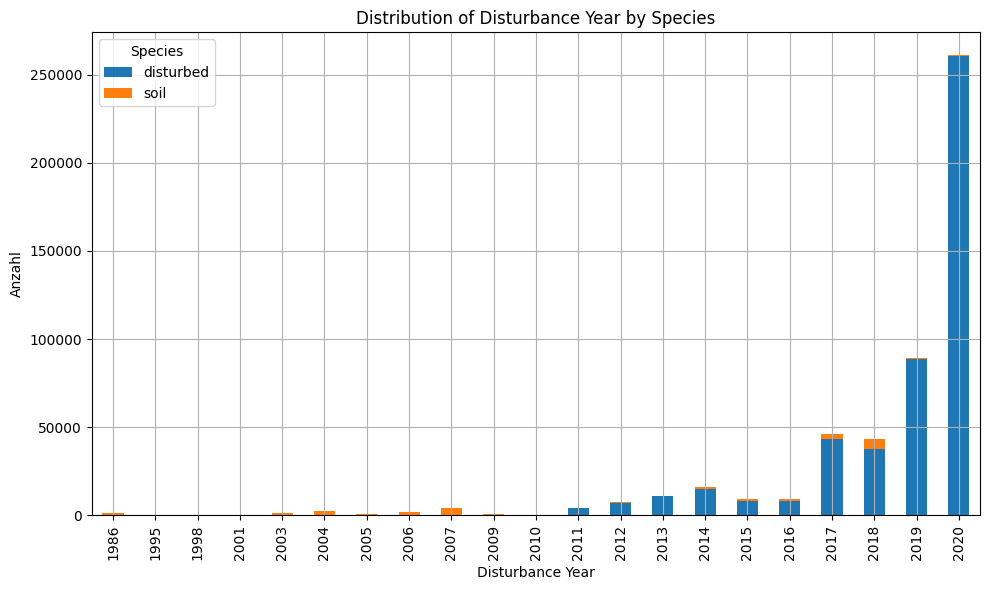

In [105]:
filtered = df[df["disturbance_year"] != 0]
crosstab = pd.crosstab(filtered["disturbance_year"], filtered["species"])
crosstab.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Disturbance Year")
plt.ylabel("Anzahl")
plt.title("Distribution of Disturbance Year by Species")
plt.legend(title="Species")
plt.tight_layout()
plt.grid()
plt.show()

In [106]:
filtered.sort_values(by="disturbance_year", ascending=True)

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi,disturbed
3931490,2018-04-07,11759,1986,97,463,739,669,1308,3089,3351,...,0.638631,3091.5,1.083171,1.009767,0.836630,999.476233,-30.459293,-0.999708,2757,True
3931502,2018-07-03,11759,1986,184,500,833,908,1572,2855,3065,...,0.572601,2905.0,1.036537,0.861511,0.787204,919.654626,-34.303975,-0.999702,2451,True
3931503,2018-07-22,11759,1986,203,444,773,574,1202,2649,3111,...,0.601957,3160.0,1.102043,1.071615,0.857249,1052.064111,-35.412578,-0.999710,2873,True
3931504,2018-07-25,11759,1986,206,373,720,543,1097,2585,3034,...,0.616409,3122.5,1.106416,1.086095,0.862078,895.378269,-33.747984,-0.999705,2851,True
3931505,2018-07-30,11759,1986,211,420,752,577,1136,2803,3284,...,0.627354,3457.5,1.110430,1.099456,0.866528,880.449220,-32.739052,-0.999733,3169,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391275,2021-09-10,28209,2020,253,277,421,389,629,1059,1160,...,0.467426,1136.5,1.023560,0.821273,0.773837,310.457584,-35.695349,-0.999249,942,True
2405048,2017-07-20,6,2020,201,189,304,196,434,1410,1836,...,0.715888,1666.0,1.140175,1.199694,0.900000,421.600000,-33.334016,-0.999433,1568,True
2405047,2017-07-16,6,2020,197,258,398,260,542,1549,2020,...,0.670802,1802.0,1.123732,1.143900,0.881387,470.289231,-34.798411,-0.999483,1672,True
2405046,2017-06-18,6,2020,169,95,263,137,430,1535,1857,...,0.751887,1787.5,1.167270,1.293454,0.931259,735.708029,-30.886878,-0.999461,1719,True


In [107]:
filtered = df[df["disturbance_year"] != 0]
id_df = filtered[filtered["id"]==11759]
id_df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi,disturbed
3931467,2017-02-18,11759,1986,49,482,712,916,1468,2206,2342,...,0.533726,2085.0,0.985072,0.705449,0.735184,707.717031,-39.685637,-0.999607,1627,True
3931468,2017-03-13,11759,1986,72,519,807,893,1467,2378,2740,...,0.544968,2335.5,1.006982,0.770916,0.757007,754.363270,-41.390779,-0.999641,1889,True
3931469,2017-03-26,11759,1986,85,387,698,527,1199,2808,3433,...,0.662067,3295.5,1.114471,1.112933,0.871023,1223.116509,-36.431945,-0.999719,3032,True
3931470,2017-04-09,11759,1986,99,351,692,483,1160,2966,3551,...,0.673816,3332.5,1.123340,1.142699,0.880947,1300.737060,-34.230343,-0.999720,3091,True
3931471,2017-04-10,11759,1986,100,335,631,444,1156,3155,3667,...,0.706375,3951.0,1.143533,1.211370,0.903834,1483.012613,-32.474237,-0.999760,3729,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931644,2022-08-09,11759,1986,221,565,847,1219,1624,2037,2281,...,0.458440,2015.5,0.930465,0.548576,0.682882,431.645611,-53.665860,-0.999619,1406,True
3931645,2022-08-13,11759,1986,225,576,863,1237,1776,2147,2351,...,0.462974,1992.5,0.925780,0.535533,0.678534,619.087470,-62.954178,-0.999617,1374,True
3931646,2022-08-13,11759,1986,225,623,871,1352,1733,2025,2417,...,0.470195,1890.0,0.899918,0.464719,0.654926,390.694083,-76.482877,-0.999610,1214,True
3931647,2022-09-16,11759,1986,259,344,743,339,981,3344,3996,...,0.686432,3875.5,1.159891,1.267875,0.922673,1486.258407,-31.071096,-0.999753,3706,True


In [116]:
band_columns = [col for col in id_df.columns if col.startswith("b")]
fig = px.line(
    id_df,
    x="time",
    y= band_columns,
    markers="o")
fig.show()

## Correlation Analysis

In [ ]:
correlation = CorrelationAnalysis(df)
corr_matrix = correlation.get_correlation_matrix()
corr_matrix

In [ ]:
top_corr_df = correlation.get_top_correlations(top_n=15)
plot_top_correlations(top_corr_df)

In [ ]:
correlation.plot_correlation_matrix()

In [ ]:
correlation.plot_correlation_distribution(sample_size= 100)

## Explore Spectral

In [ ]:
spectral = SpectralBandPlotter(df)
spectral.plot_all_years(sample_size=500, showfliers=True)

In [ ]:
spectral.plot_per_year(sample_size=500)

In [ ]:
spectral.plot_species_season_distribution()

## Time Series Analysis

In [ ]:
data = df["date_diff"].dropna()
median_val = data.median()

plt.figure(figsize=(10, 5))
plt.hist(data, bins=20, color="black")

plt.axvline(
    median_val,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median: {median_val:.1f}",
)

plt.title("Distribution of Time Gaps (in Days)")
plt.xlabel("Days Between Observations")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
ts_agg = TimeSeriesAggregate(id_df)
df_2w = ts_agg.aggregate_timeseries(freq="2W", method="median")
dataloader = DataLoader()
df_2w_features = dataloader.date_feature_extraction(df_2w)

In [109]:
spectral = SpectralBandPlotter(df_2w_features)
spectral.plot_spectral_development_over_years(addition="aggregated")